In [2]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import mw_protocol.toolbox as tb
import mw_protocol.routing as routing
import mw_protocol.spreading as spreading
import mw_protocol.plotting as plotting
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_context("poster")

In [4]:
# To change to your personal directory
script_folder = "/nfs/see-fs-01_users/eeymr/work/scripts/mw_protocol/"

## Calculating Sea level change

In [4]:
ds_wfix = xr.open_dataset("/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.waterfix.nc").isel(t=0).isel(depth=0)
ds_wfix

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 290)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    depth      float32 5.0
    t          object 1800-12-01 00:00:00
Data variables:
    field672   (latitude, longitude) float32 ...
Attributes:
    history:  Thu Jan 18 08:19:59 GMT 2018 - CONVSH V1.91 16-February-2006

In [7]:
ds_wfix_patch = xr.open_dataset("/nfs/annie/eeymr/work/outputs/glac_mw/archive/Proj_GLAC1D/corrected_waterfix/teadv3.qrparam.waterfix.hadcm3.corrected.nc").isel(t=0).isel(depth=0)
ds_wfix_patch

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 290)
Coordinates:
    t          object 1800-12-01 00:00:00
    depth      float32 5.0
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
Data variables:
    field672   (latitude, longitude) float32 ...
Attributes:
    title:    Corrected waterfix for teadv3 based on the drift of 21k between...
    history:  Created 2020-02-18 23:00:41.109453 by Yvan Romé

In [8]:
ds_discharge = xr.open_dataset("/nfs/annie/eeymr/work/outputs/glac_mw/xosf/temev.discharge.glac_mw.nc", decode_times=False)
ds_discharge

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 211)
Coordinates:
  * t          (t) int64 -21000 -20900 -20800 -20700 -20600 ... -300 -200 -100 0
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -21
    end_year:     0
    step:         100
    mode:         spreaded
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 20:45:24.325024 by Yvan Romé

In [9]:
surface = tb.surface_matrix(ds_discharge.longitude,ds_discharge.latitude)
surface_total = np.nansum(surface)
surface_total*10**-12 # km**2

510.06447190978827

In [10]:
wfix = np.nansum(ds_wfix.field672.values[:,:-2]*surface*10**-9)
wfix_patch = np.nansum(ds_wfix_patch.field672.values[:,:-2]*surface*10**-9)
discharge = np.nansum(((ds_discharge.discharge.values - ds_wfix.field672.values[:,:-2])*surface*10**-9),axis=(1,2))

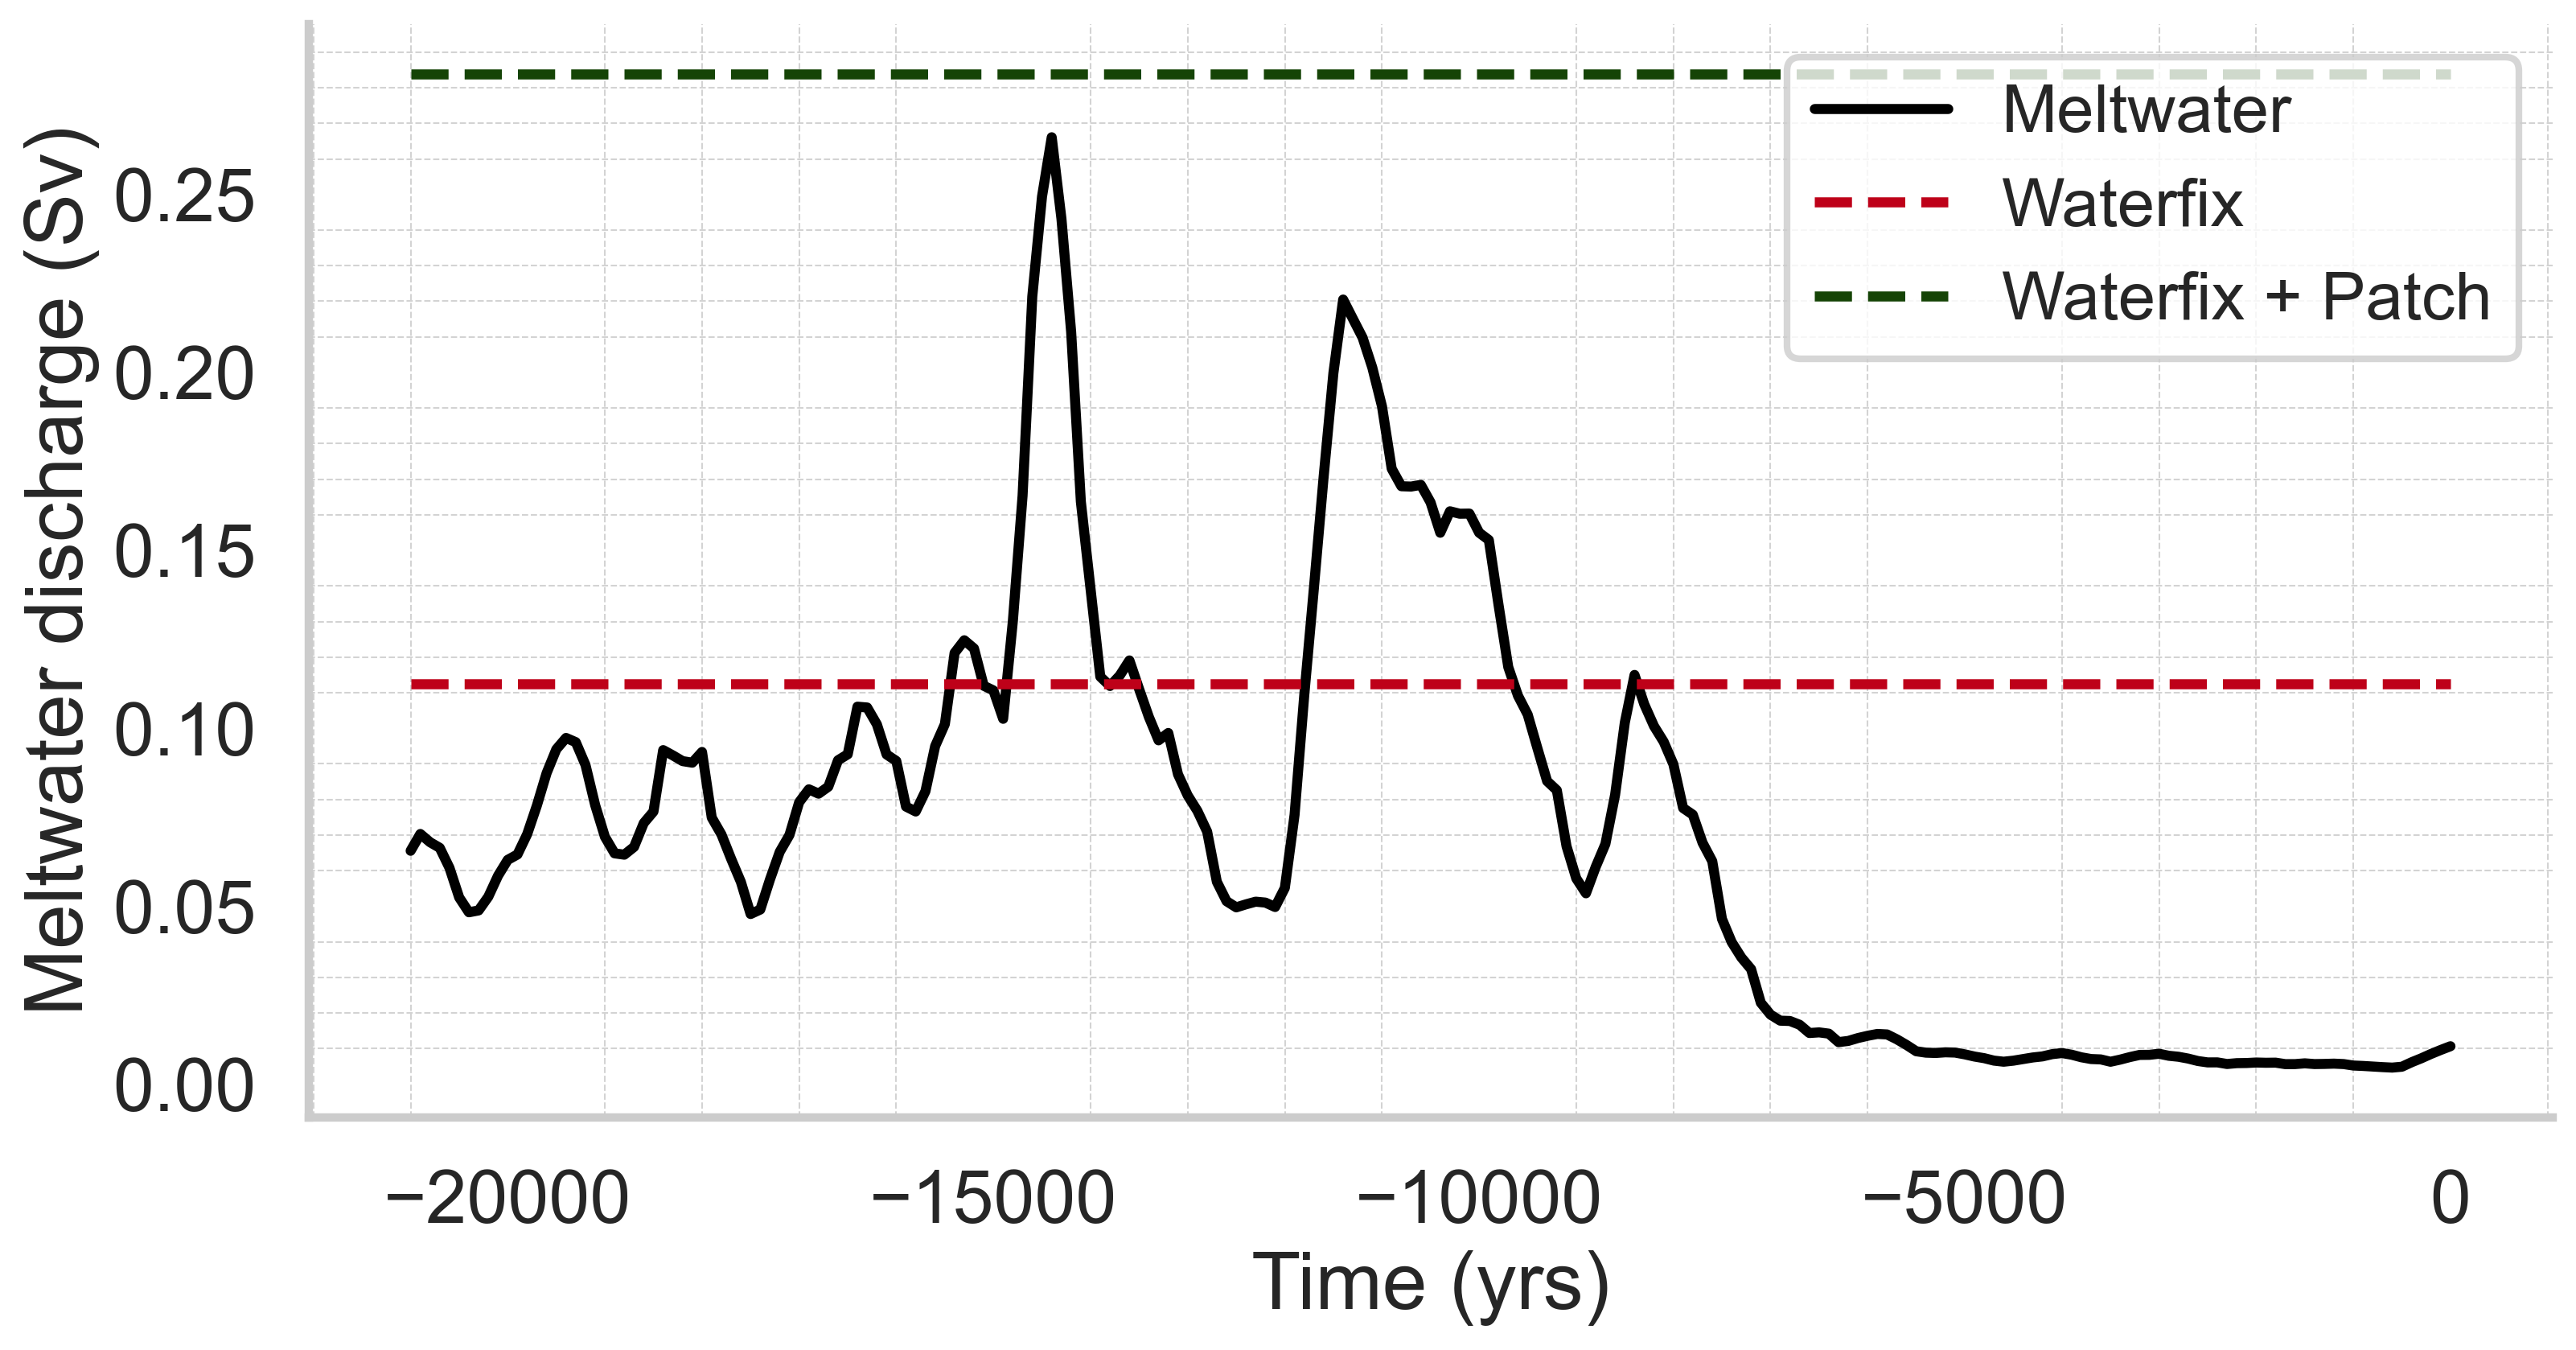

In [13]:
figMap, axMw = plt.subplots(nrows=1, ncols=1, figsize=(12,6), dpi=300)

axMw.plot(ds_discharge.t, tb.rmean(discharge,5), label="Meltwater", color="xkcd:black", linestyle="-")
axMw.plot(ds_discharge.t, [wfix]*(len(ds_discharge.t)), label="Waterfix", color="xkcd:scarlet", linestyle="--")
axMw.plot(ds_discharge.t, [wfix_patch]*(len(ds_discharge.t)), label="Waterfix + Patch", color="xkcd:forrest green", linestyle="--")

axMw.legend(loc="upper right", fontsize='small')
axMw.spines['right'].set_visible(False)
axMw.spines['top'].set_visible(False)
axMw.set_xlabel("Time (yrs)")
axMw.set_ylabel("Meltwater discharge (Sv)")
axMw.minorticks_on()
axMw.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

In [14]:
def calculate_slr(discharge, lon, lat, time, wfix=None):

    delta_t = (time[1] - time[0])*3600*24*360
    ro = 1000
        
    lsm = discharge[0]/discharge[0]
    surface_matrix = tb.surface_matrix(lon,lat) * lsm
    surface_total = np.nansum(surface_matrix)
    
    slr_t = np.zeros(len(time))
    slr_c = np.zeros(len(time))

    for t in range(discharge.shape[0]):
        if wfix is not None:
            slr_t[t] = np.nansum(delta_t * (discharge[t] - wfix)*surface_matrix/surface_total/ro)
            slr_c[t] = np.sum(slr_t)
        else:
            slr_t[t] = np.nansum(delta_t * (discharge[t])*surface_matrix/surface_total/ro)
            slr_c[t] = np.sum(slr_t)
    
    return slr_t, slr_c

In [15]:
lon, lat, t = ds_discharge.longitude.values, ds_discharge.latitude.values, ds_discharge.t.values
wfix = ds_wfix.field672.values[:,:-2]
wfix_values = np.resize(wfix, (len(t), wfix.shape[0], wfix.shape[1]))
wfix_patch_values = np.resize(ds_wfix_patch.field672.values[:,:-2], (len(t), wfix.shape[0], wfix.shape[1]))

slr_t, slr_c = calculate_slr(ds_discharge.discharge.values, lon, lat, t, wfix = wfix)
slr_wfix, slr_wfix_c = calculate_slr(wfix_values, lon, lat, t)
slr_wfix_patch, slr_wfix_patch_c = calculate_slr(wfix_patch_values, lon, lat, t)

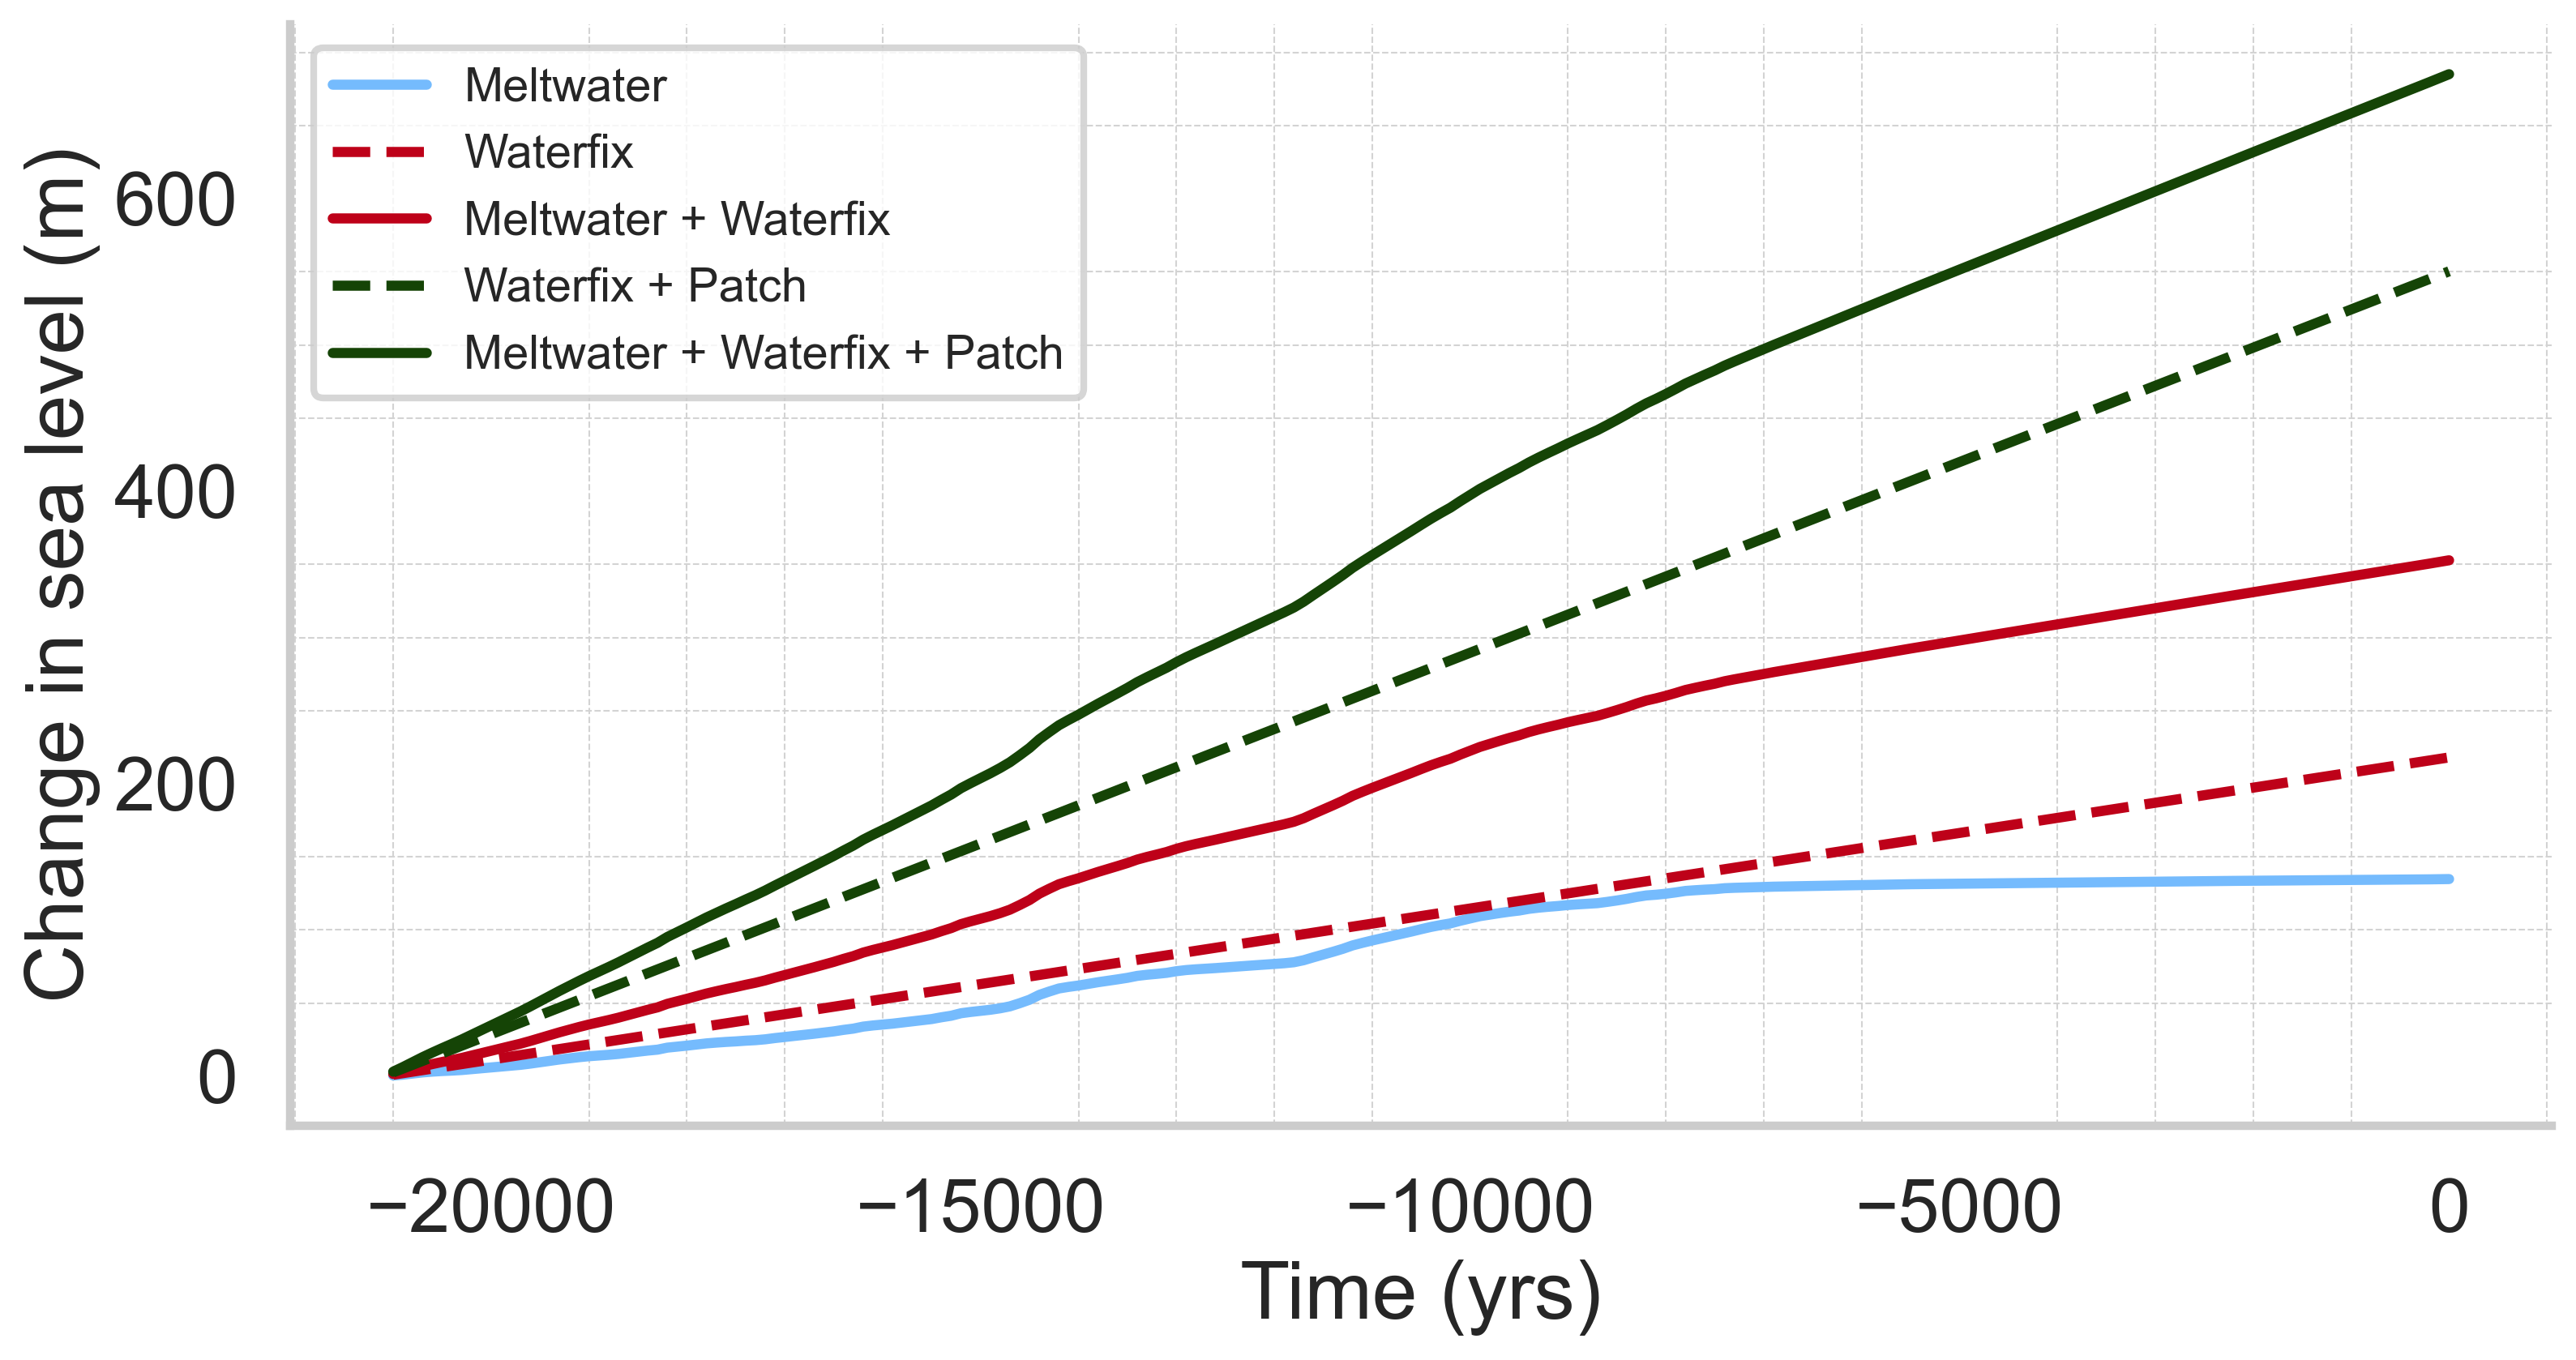

In [20]:
figMap, axMw = plt.subplots(nrows=1, ncols=1, figsize=(12,6), dpi=300)

axMw.plot(ds_discharge.t, slr_c, label="Meltwater", color="xkcd:sky blue", linestyle="-")
axMw.plot(ds_discharge.t, slr_wfix_c, label="Waterfix", color="xkcd:scarlet", linestyle="--")
axMw.plot(ds_discharge.t, slr_c + slr_wfix_c, label="Meltwater + Waterfix", color="xkcd:scarlet", linestyle="-")
axMw.plot(ds_discharge.t, slr_wfix_patch_c, label="Waterfix + Patch", color="xkcd:forrest green", linestyle="--")
axMw.plot(ds_discharge.t, slr_c + slr_wfix_patch_c, label="Meltwater + Waterfix + Patch", color="xkcd:forrest green", linestyle="-")

axMw.legend(loc="upper left", fontsize='xx-small')
axMw.spines['right'].set_visible(False)
axMw.spines['top'].set_visible(False)
axMw.set_xlabel("Time (yrs)")
axMw.set_ylabel("Change in sea level (m)")
axMw.minorticks_on()
axMw.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

## Regridding benchmark

In [27]:
ds_hice = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
# ds_hice = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DHiceF26.nc')
lon_glac1d, lat_glac1d, t_glac1d = ds_hice.XLONGLOBP5.values, ds_hice.YLATGLOBP25.values, ds_hice.T122KP1.values
lon_glac1d_b, lat_glac1d_b = tb.create_coordinate_edges(lon_glac1d), tb.create_coordinate_edges(lat_glac1d)

ds_lsm = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/ocean_masks/teadv3.qrparm.omask.nc')
# ds_lsm = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/lsm/teadv3.qrparm.omask.nc')
lon_hadcm3, lat_hadcm3, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.lsm.values

lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)

ds_pointer = xr.open_dataset('/Documents/Documents/Cours/PHD/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')
# ds_pointer = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1DdrainagePointerF26ka.nc')

projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
# projection_map = ccrs.PlateCarree()

ds_out = xr.Dataset(coords={'lon': (['x'], lon_hadcm3),
                          'lat': (['y'], lat_hadcm3),
                          'lon_b': (['x_b'], lon_hadcm3_b),
                          'lat_b': (['y_b'], lat_hadcm3_b)
                          })

ds_in = xr.Dataset(coords={'lon': (['x'], lon_glac1d),
                         'lat': (['y'], lat_glac1d),
                         'lon_b': (['x_b'], lon_glac1d_b),
                         'lat_b': (['y_b'], lat_glac1d_b),
                         })

#Input

t = np.where(t_glac1d == -21)[0][0]
converted_mask = routing.hi_to_discharge(ds_hice, t, "Volume")
ix, jy = ds_pointer.IX.sel(T40H1=-21).values, ds_pointer.JY.sel(T40H1=-21).values
routed_mask = routing.routing_method(converted_mask, ix, jy)

____ Computation time step : 50.
____ Routing method.


### Bilinear algorithm

Reuse existing file: bilinear_720x720_144x288.nc
Before regriding -> flux : 57378.17 , max : 7141.82
After regriding  -> flux : 57378.17 , max : 35186.39


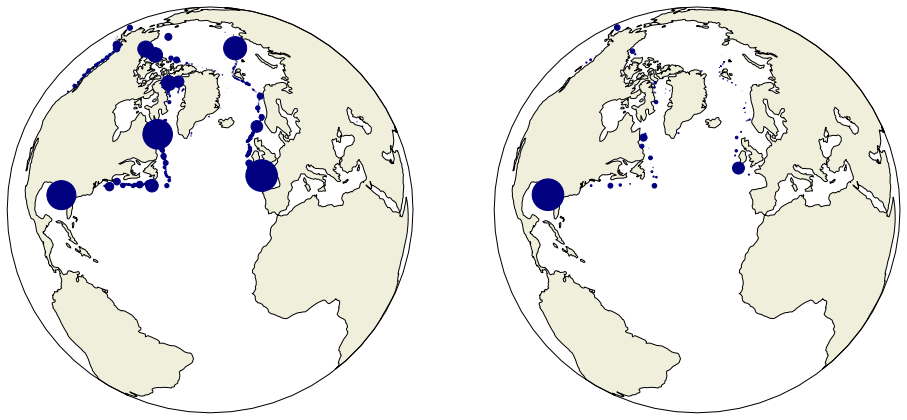

In [20]:
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', reuse_weights=True)

# Output
routed_mask_out = regridder(routed_mask)
routed_mask_out = routed_mask_out*np.nansum(routed_mask)/np.nansum(routed_mask_out)

print(f"Before regriding -> flux : {np.nansum(routed_mask):.2f} , max : {np.nanmax(routed_mask):.2f}")
print(f"After regriding  -> flux : {np.nansum(routed_mask_out):.2f} , max : {np.nanmax(routed_mask_out):.2f}")

# Maps
figMap, (axInit, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': projection_map},
                                        figsize=(16, 8))

x, y, s = plotting.scatter_mask(routed_mask)
axInit.scatter(lon_glac1d[x], lat_glac1d[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axInit.set_global()
axInit.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x, y, s = plotting.scatter_mask(routed_mask_out)
axRouted.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

### Conservative

Reuse existing file: conservative_720x720_144x288.nc
Before regriding -> sum : 57378.17 , max : 7141.82
After regriding  -> sum : 57378.17 , max : 7165.95


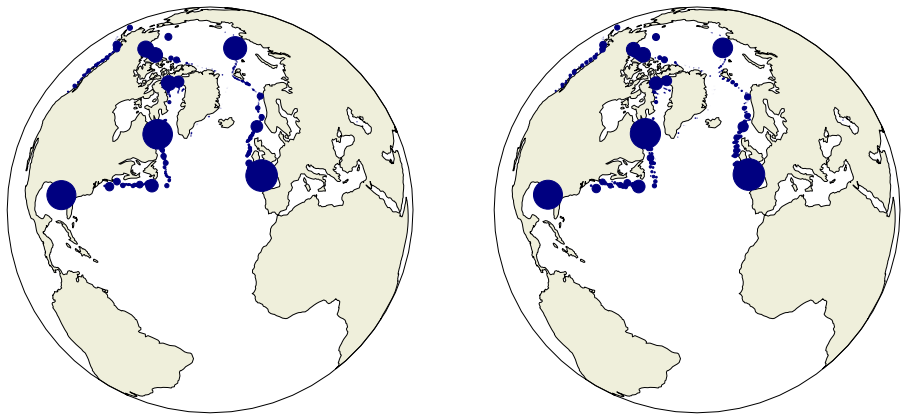

In [19]:
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights=True)

# Output
routed_mask_out = regridder(routed_mask)
routed_mask_out = routed_mask_out*np.nansum(routed_mask)/np.nansum(routed_mask_out)

print(f"Before regriding -> sum : {np.nansum(routed_mask):.2f} , max : {np.nanmax(routed_mask):.2f}")
print(f"After regriding  -> sum : {np.nansum(routed_mask_out):.2f} , max : {np.nanmax(routed_mask_out):.2f}")

# Maps
figMap, (axInit, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': projection_map},
                                        figsize=(16, 8))

x, y, s = plotting.scatter_mask(routed_mask)
axInit.scatter(lon_glac1d[x], lat_glac1d[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axInit.set_global()
axInit.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x, y, s = plotting.scatter_mask(routed_mask_out)
axRouted.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

### Homemade attempt

Before regriding -> sum : 57378.17 , max : 7141.82
After regriding  -> sum : 57378.17 , max : 7141.82


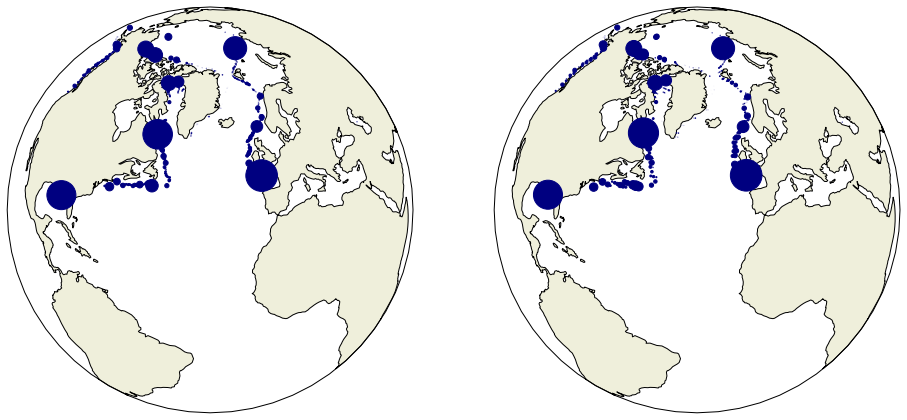

In [24]:
divided_array = np.zeros((routed_mask.shape[0], routed_mask.shape[1]*2))
for i in range(routed_mask.shape[0]):
    for j in range(routed_mask.shape[1]):
        divided_array[i,2*j] = routed_mask[i,j]/2
        divided_array[i,2*j+1] = routed_mask[i,j]/2
                
tab_out = np.zeros((routed_mask_out.shape[0], routed_mask_out.shape[1]))
for i in range(tab_out.shape[0]):
    for j in range(tab_out.shape[1]):
        tab_out[i,j] = np.sum(divided_array[5*i:5*i+5,5*j:5*j+5])
        
# Output

print(f"Before regriding -> sum : {np.nansum(routed_mask):.2f} , max : {np.nanmax(routed_mask):.2f}")
print(f"After regriding  -> sum : {np.nansum(tab_out):.2f} , max : {np.nanmax(tab_out):.2f}")

# Maps
figMap, (axInit, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': projection_map},
                                        figsize=(16, 8))

x, y, s = plotting.scatter_mask(routed_mask)
axInit.scatter(lon_glac1d[x], lat_glac1d[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axInit.set_global()
axInit.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x, y, s = plotting.scatter_mask(tab_out)
axRouted.scatter(lon_hadcm3[x]-180, lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Overlaping algorithm options

These points are now to be shifted in the sea : we consider the closest sea points of the discharge point and we distribute the meltwater rate. To determine the closest neighbours, I propose 4 different algorithms to do so :  (double longitude / simple longitude) and (square / cross).

### Square simple longitude

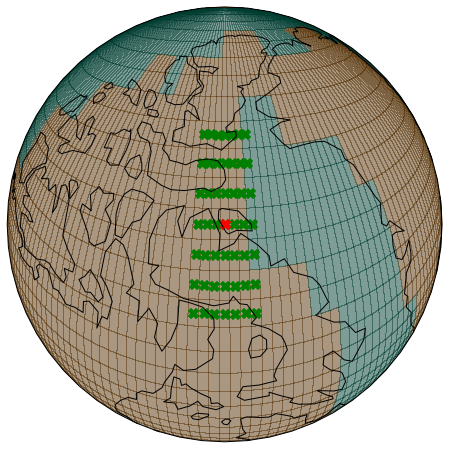

In [30]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-radius,radius +1):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()

### Square double longitude

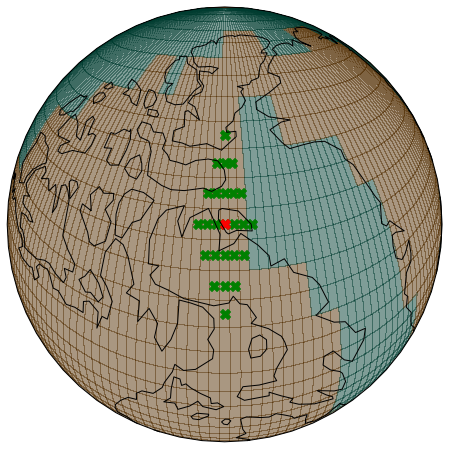

In [32]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-(radius//2),(radius)//2+1):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()

### Cross simple longitude

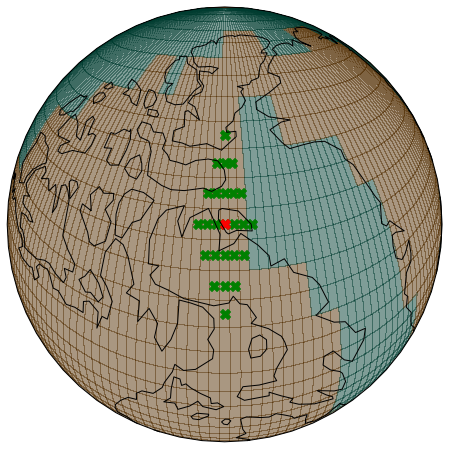

In [33]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-(radius - abs(i)),(radius-abs(i)+1)):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()

### Cross double longitude

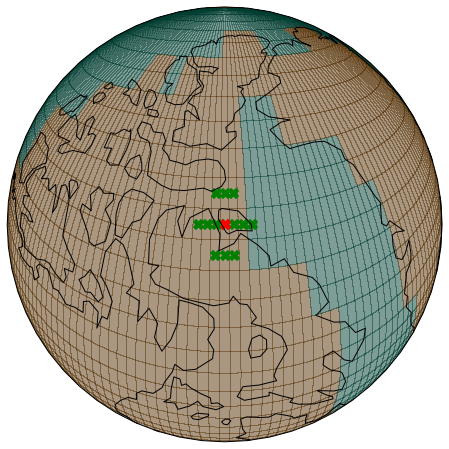

In [34]:
i_can, j_can = 224, 130

projection_map = ccrs.NearsidePerspective(central_longitude=lon_hadcm3[i_can], central_latitude=lat_hadcm3[j_can],
                                            satellite_height=300000)

i_sea_points, j_sea_points, lon_sea_points, lat_sea_points = [], [], [], []
radius = 3

for i in range(-radius, radius +1):
    for j in range(-((radius - abs(i))//2),(radius-abs(i))//2+1):
        i_sea_points.append(i_can + i), j_sea_points.append(j_can + j)
        lon_sea_points.append(lon_hadcm3[i_can + i]), lat_sea_points.append(lat_hadcm3[j_can + j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_sea_points, lat_sea_points, transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axMap.scatter(lon_hadcm3[i_can], lat_hadcm3[j_can], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.coastlines()
axMap.set_global()